TESTING CONVERT FUNCTIONS FOR PHOIBOS 150 DATA, COMPARISON WITH THE IGOR DATA


USES THE FOLDER dataEPFL/R1932

the folder contains all the igor output arrays for comparison



In [46]:
# This uses the autoreload function form ipynb, useful to reload modificaiton of the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

spa = SpecsAnalyzer()

import os

testdatapath = "../tests/data/dataEPFL/R9132/"
filelist = os.listdir(testdatapath)
print("Data path= ", testdatapath)
# this folders contains the AVG folder with the data, an info.txt vector and a scan vector

Data path=  ../tests/data/dataEPFL/R9132/


../tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv
The shape of the raw data is:  (256, 344)


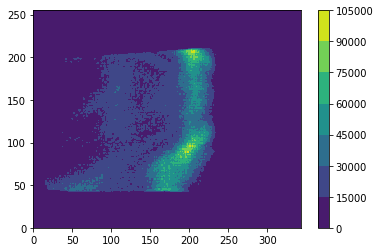

In [48]:
# get the raw image name from the list
rawimagelist = [i for i in filelist if "RAWDATA" in i]
raw_image_name = os.path.join(testdatapath, rawimagelist[0])
print(raw_image_name) 

with open(raw_image_name) as file:
    tsv_data = np.loadtxt(file, delimiter="\t")
plt.figure()
h = plt.contourf(tsv_data)
plt.colorbar()
print("The shape of the raw data is: ", tsv_data.shape)
# plt.xlim(120,150)
# plt.ylim(150,200)

In [49]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

spa = SpecsAnalyzer()
scanparameters = spa.config

In [50]:
# load the module and import functions for reading the parameter table from the calib2d file
import specsanalyzer.convert

# let's get all the functions to be tested
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_rr_da
from specsanalyzer.convert import calculate_polynomial_coef_da
from specsanalyzer.convert import mcp_position_mm

In [51]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# call an instance of the class
spa = SpecsAnalyzer()
# io function used to get the calib 2d file in the class
calib2d_dictionary = specsanalyzer.io.parse_calib2d_to_dict(
    "../specsanalyzer/config/phoibos150.calib2d"
)
# calib2d_dictionary=specsanalyzer.io.parse_calib2d_to_dict('./config/phoibos150.calib2d')

# settings function used to get  configuration files
config_file = specsanalyzer.settings.parse_config(calib2d_dictionary)


# get the das  and the rr vector
# rr_array, da_matrix=  specsanalyzer.convert.get_rr_da("WideAngleMode", config_file)

In [52]:
# Load the IGOR txt Di_coeff values for comparison
igordatapath = "../tests/data/dataEPFL/R9132"
igordatapath_content = os.listdir(igordatapath)

# get the fitted coefficients
Di_coef_list = [i for i in igordatapath_content if "_coef" in i]

igor_D_coef_list = []
for i, name in enumerate(sorted(Di_coef_list)):
    tmp_name = os.path.join(igordatapath, name)
    with open(tmp_name) as file:
        # check the name in row 1
        # first_line=file.readline()
        # print(first_line)

        # igor_D_coef_list.append(np.loadtxt(file, delimiter='\t', skiprows=1) )
        igor_D_coef_list.append(np.loadtxt(file, delimiter="\t"))
# igor_D_coef_matrix=np.vstack(igor_D_coef_list)
igor_D_coef_matrix = np.flip(np.vstack(igor_D_coef_list), axis=1)
print(igor_D_coef_matrix)  # row 0 D1 , row 1 D3, ...
print(np.vstack(igor_D_coef_list))

[[-4.4857240e-03  3.2542211e-01 -5.1406364e+00]
 [ 2.5193503e-03 -1.3771337e-01  1.7925767e+00]
 [-7.4261258e-04  2.9766740e-02 -1.8274546e-01]
 [-5.1501684e-05  9.3138171e-03 -2.5310904e-01]]
[[-5.1406364e+00  3.2542211e-01 -4.4857240e-03]
 [ 1.7925767e+00 -1.3771337e-01  2.5193503e-03]
 [-1.8274546e-01  2.9766740e-02 -7.4261258e-04]
 [-2.5310904e-01  9.3138171e-03 -5.1501684e-05]]


In [53]:
# Load the IGOR txt Da_values for comparison
igordatapath = "../tests/data/dataEPFL/R9132"
igordatapath_content = os.listdir(igordatapath)

# get the fitted coefficients
Di_value_list = [i for i in igordatapath_content if "_value.tsv" in i]

igor_D_value_list = []
for i, name in enumerate(sorted(Di_value_list)):
    tmp_name = os.path.join(igordatapath, name)
    with open(tmp_name) as file:
        # check the name in row 1
        # first_line=file.readline()
        # print(first_line)

        # igor_D_value_list.append(np.loadtxt(file, delimiter='\t', skiprows=1) )
        igor_D_value_list.append(np.loadtxt(file, delimiter="\t"))

igor_D_value_matrix = np.vstack(igor_D_value_list)

In [54]:
Di_value_list
type(Di_value_list)

list

In [55]:
# let's calculate the corresponding quantities in Pytohn

# load the module and import functions for reading the parameter table from the calib2d file
import specsanalyzer.convert

# let's get all the functions to be tested
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_rr_da
from specsanalyzer.convert import calculate_polynomial_coef_da
from specsanalyzer.convert import mcp_position_mm
from specsanalyzer.convert import calculate_matrix_correction


spa = SpecsAnalyzer(config="../tests/data/dataEPFL/config/config.yaml")
config_dict = spa.config
lens_mode = "WideAngleMode"
kinetic_energy = 35.000000
pass_energy = 35.000000
work_function = 4.2
binning = 4

eshift = np.array(config_dict["calib2d_dict"]["eShift"])

aInner, damatrix = get_damatrix_fromcalib2d(
    lens_mode,
    kinetic_energy,
    pass_energy,
    work_function,
    config_dict,
)

dapolymatrix = calculate_polynomial_coef_da(
    damatrix, kinetic_energy, pass_energy, eshift
)


# note that for scan 9132 (and 9131) we have   retardatio ratio=   0.88 -> this is wrong imo, checke the effect of the work function
#  rr_inf =   10  rr_factor =   0.75 in igor

In [56]:
print("das")
print(damatrix)
print(igor_D_value_matrix)
print("Difference in the interpolated D coeffiecients")
print(damatrix - igor_D_value_matrix)
# at the moment they differ by some %..

print("coefs")
print(dapolymatrix)
print(igor_D_coef_matrix)
print("Difference in the fitted polynomial coeffiecients")
print(dapolymatrix - igor_D_coef_matrix)
# at the moment they differ by some %..




das
[[ 7.204000e-01  7.541250e-01  7.603750e-01]
 [-1.093975e-03  5.881250e-02  1.341500e-01]
 [-1.400600e-02 -5.061000e-02 -9.176250e-02]
 [-3.629475e-04  9.785000e-03  1.961750e-02]]
[[ 7.2039998e-01  7.5412500e-01  7.6037496e-01]
 [-1.0939732e-03  5.8812503e-02  1.3415000e-01]
 [-1.4006001e-02 -5.0609998e-02 -9.1762498e-02]
 [-3.6294712e-04  9.7850002e-03  1.9617500e-02]]
Difference in the interpolated D coeffiecients
[[ 2.00000000e-08 -1.11022302e-16  4.00000000e-08]
 [-1.80000000e-09 -3.00000001e-09  0.00000000e+00]
 [ 9.99999999e-10 -2.00000000e-09 -2.00000000e-09]
 [-3.80000000e-10 -2.00000001e-10  0.00000000e+00]]
coefs
[[-4.48571429e-03  3.25421429e-01 -5.14062500e+00]
 [ 2.51935102e-03 -1.37713436e-01  1.79257775e+00]
 [-7.42612245e-04  2.97667143e-02 -1.82745000e-01]
 [-5.15016327e-05  9.31381357e-03 -2.53108975e-01]]
[[-4.4857240e-03  3.2542211e-01 -5.1406364e+00]
 [ 2.5193503e-03 -1.3771337e-01  1.7925767e+00]
 [-7.4261258e-04  2.9766740e-02 -1.8274546e-01]
 [-5.1501684e-0

In [57]:
print(np.testing.assert_allclose(dapolymatrix, igor_D_coef_matrix, rtol=1e-05))

None


In [58]:
# get the rr and the damatrix
rr, damatrix = get_rr_da("WideAngleMode", config_dict)

The shape of the jacobian_reference is:  (256, 344)
The shape of the jacobian_determinant is:  (256, 344)


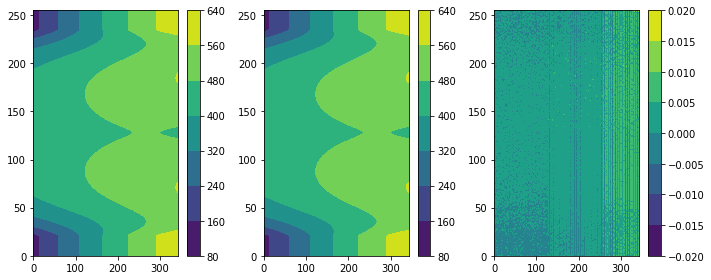

In [59]:
# let's get the jacobian matrices generate by the igor code
# and compare it to the one obtained by calculate_matrix_correction

# Jacobian
jname = [i for i in igordatapath_content if "Jacobian" in i][0]
with open(os.path.join(igordatapath, jname)) as file:
    jacobian_reference = np.loadtxt(file, delimiter="\t").T

print(
    "The shape of the jacobian_reference is: ",
    jacobian_reference.shape,
)
# plt.xlim(120,150)
# plt.ylim(150,200)


(
    ek_axis,
    angle_axis,
    angular_correction_matrix,
    e_correction,
    jacobian_determinant,
) = calculate_matrix_correction(
    lens_mode,
    kinetic_energy,
    pass_energy,
    work_function,
    binning,
    config_dict,
)


print(
    "The shape of the jacobian_determinant is: ",
    jacobian_determinant.shape,
)

delta_jacobian = jacobian_determinant - jacobian_reference

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))
subplot1 = ax1.contourf(jacobian_determinant)
subplot2 = ax2.contourf(jacobian_reference)
subplot3 = ax3.contourf(delta_jacobian)
fig.colorbar(subplot1, ax=ax1)
fig.colorbar(subplot2, ax=ax2)
fig.colorbar(subplot3, ax=ax3)

plt.tight_layout()

In [60]:
assert np.testing.assert_allclose(jacobian_determinant, jacobian_reference, rtol=1e-04) is None

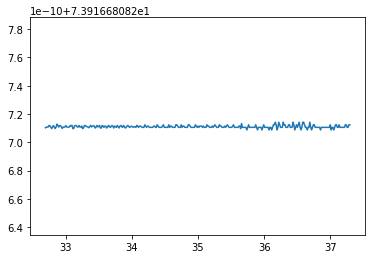

In [61]:
# plt.plot(ek_axis,e_correction)
d_ecorrection = np.gradient(e_correction, ek_axis)
plt.plot(ek_axis, d_ecorrection)

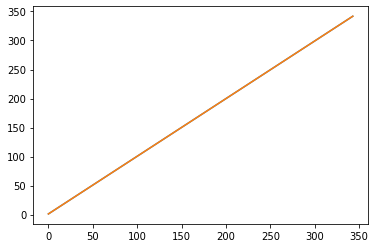

In [62]:
# e_correction
jname = [i for i in igordatapath_content if "E_Correction" in i][0]
jname
with open(os.path.join(igordatapath, jname)) as file:
    e_correction_reference = np.loadtxt(file, delimiter="\t")

plt.plot(e_correction)
plt.plot(e_correction_reference)

# ecorrection is different!!

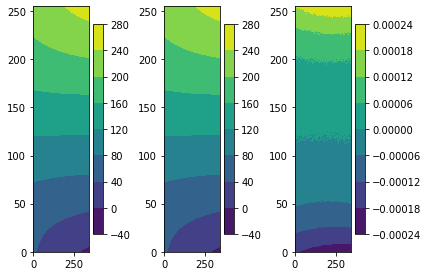

In [63]:
# e_correction
jname = [i for i in igordatapath_content if "Angular_Correction" in i][0]
jname
with open(os.path.join(igordatapath, jname)) as file:
    angle_correction_reference = np.loadtxt(file, delimiter="\t").T

delta_angle = angle_correction_reference - angular_correction_matrix

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
subplot1 = ax1.contourf(angular_correction_matrix)
subplot2 = ax2.contourf(angle_correction_reference)
subplot3 = ax3.contourf(delta_angle)
fig.colorbar(subplot1, ax=ax1)
fig.colorbar(subplot2, ax=ax2)
fig.colorbar(subplot3, ax=ax3)
plt.tight_layout()

In [64]:
import os
print(os.path.curdir)
# os.path.join(os.path.curdir, 'file.name')

.


In [65]:

os.fspath('./tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv')

'./tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv'

In [130]:
def test_conversion():
    "Test if the conversion pipeline gives the same result as the Igor procedures"

    #execution path: if you run in jupyter is is ".", in the case of the test should already by under tests
    cwd=os.getcwd()
    
    if os.path.basename(cwd)=="specsanalyser":
        "ok we are HERE"
        basepath=cwd
    else:
        basepath=os.path.dirname(cwd)
    # get the raw data
    print(basepath)
    data_path = os.path.join(basepath,'tests' ,'data', 'dataEPFL', 'R9132')
    raw_image_name = os.path.join(data_path,"Data9132_RAWDATA.tsv")
    
    # raw_image_name=os.fsencode('tests\data\dataEPFL\R9132\Data9132_RAWDATA.tsv')
    print(raw_image_name, "C:\\Users\\Michele\\Documents\\GitHub\\vscode\\specsanalyzer\\tests\\data\\dataEPFL\\R9132\\Data9132_RAWDATA.tsv")

    with open(raw_image_name) as file:
        tsv_data = np.loadtxt(file, delimiter="\t")
    

    # get the reference data
    reference_image_name = raw_image_name = os.path.join(data_path,"Data9132_IGOR_corrected.tsv")

    with open(reference_image_name) as file:
        reference = np.loadtxt(file, delimiter="\t")

    

    configpath = os.path.join(basepath,'tests' ,'data', 'dataEPFL', 'config',"config.yaml")
    spa = SpecsAnalyzer(config=configpath)
    lens_mode = "WideAngleMode"
    kinetic_energy = 35.000000
    pass_energy = 35.000000
    work_function = 4.2

    converted = spa.convert_image(
        raw_img=tsv_data,
        lens_mode=lens_mode,
        kinetic_energy=kinetic_energy,
        pass_energy=pass_energy,
        work_function=work_function,
        apply_fft_filter=False,
    )

    # TODO Does not work yet... Not sure how you produced the reference?

    tolerance=reference.mean()*1e-3
    np.testing.assert_allclose(converted.data, reference, atol=tolerance)

In [131]:
test_conversion()

c:\Users\Michele\Documents\GitHub\vscode\specsanalyzer
c:\Users\Michele\Documents\GitHub\vscode\specsanalyzer\tests\data\dataEPFL\R9132\Data9132_RAWDATA.tsv C:\Users\Michele\Documents\GitHub\vscode\specsanalyzer\tests\data\dataEPFL\R9132\Data9132_RAWDATA.tsv
New correction Matrix


In [ ]:
print(os.fspath(
         "./tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv",
     ))

./tests/data/dataEPFL/R9132/Data9132_RAWDATA.tsv


In [ ]:
os.fsdecode("tests\data\dataEPFL\R9132\Data9132_RAWDATA.tsv")

'tests\\data\\dataEPFL\\R9132\\Data9132_RAWDATA.tsv'

In [ ]:
os.fsencode("tests\data\dataEPFL\R9132\Data9132_RAWDATA.tsv")

b'tests\\data\\dataEPFL\\R9132\\Data9132_RAWDATA.tsv'

In [85]:
os.path.join(os.path.curdir,'tests' ,'data', 'dataEPFL', 'R9132')

'.\\tests\\data\\dataEPFL\\R9132'

In [92]:
from pathlib import Path
cwd = Path.cwd()
print(cwd.parent.absolute())

c:\Users\Michele\Documents\GitHub\vscode\specsanalyzer


In [94]:
os.path.basename(cwd.parent.absolute())

'specsanalyzer'